In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics

plt.rcParams['figure.figsize']=10,5

#### Introduction
Stuff boost is a game mechanic in Out of the Park Baseball where a pitcher that is listed as a starter in the game will have a certain Stuff rating, but when they are switched to a reliever by changing their listed position, their stuff rating is improved depending on various factors. Generally pitchers with two really good pitches, and average to poor supporting pitches will receive the highest boost when shifted to the bullpen, whereas pitchers with five or six pitches with similar ratings will receive little to no boost. There are other factors that play into it, but that's the gist of it.

This game mechanic is present currently in the base game for OOTP 22, and has been present in Perfect Team in previous iterations. During the introductory stream for Perfect Team 22, it was announced that stuff boost was removed from this year's iteration of Perfect Team.

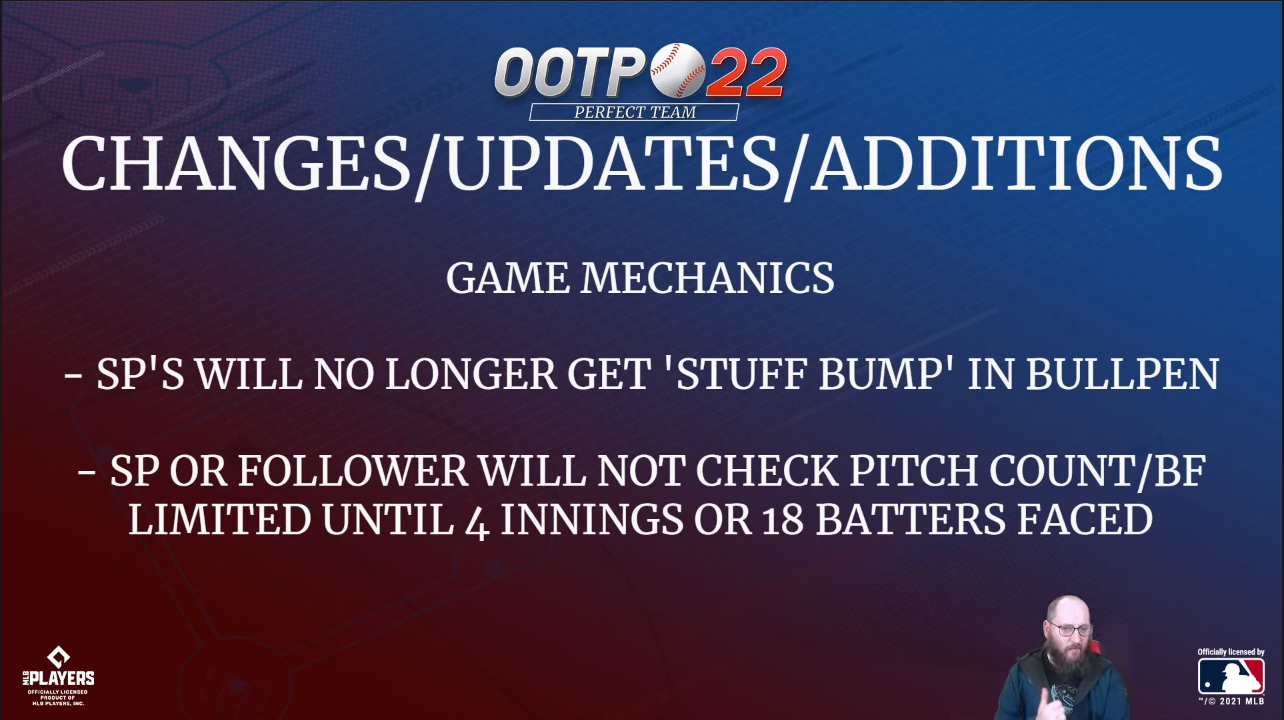

Despite this announcement, it's my belief this game mechanic is still present within PT22. The change in a pitcher's stuff may not be shown to users when they switch a pitcher's role from starter to reliever, or vice versa. 

All this analysis is trying to do is show that stuff boost is still in the Perfect Team engine. This is not intended to model the exact amount of boost that occurs to individual pitchers, or develop a precise model.

**Bronze Quick Tournaments**

The following data comes from Bronze Quick Best of Seven Tournmanets since the latest live card update that occured on June 28th, 2021. At the time I put this analysis together, I had pulled 270 tournaments worth of data, and approximately 3.7 million plate appearances. 

Pitchers who appeared as both a reliever and a starter for a team in the tournament were removed from this data, leaving only pitchers who appeared in relief in the following section. Further, only those pitchers who faced more than 1,000 batters as a reliever were included as a way to tamp down on the inherent noise that occurs when sample sizes are smaller than that (even 1,000 BF might be a little low to be honest). For this notebook, strikeout rate is defined as the number of batters struck out divided by the total number of batters faced.

<AxesSubplot:xlabel='pitching_ratings_vsr_stuff', ylabel='k_rate'>

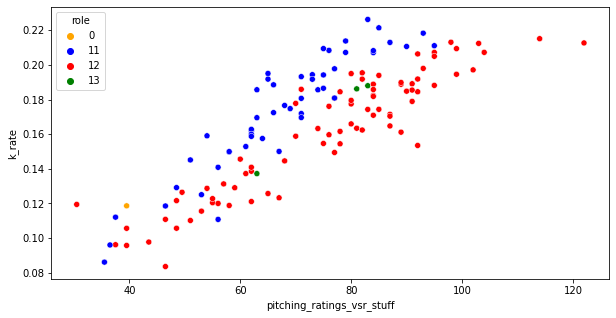

In [2]:
bz_relief = pd.read_csv('bronze_relief.csv')
#When I load the data from the card db, I convert ratings to 1-200 scale. This is just reversing that conversion
bz_relief['pitching_ratings_vsr_stuff'] = bz_relief['pitching_ratings_vsr_stuff'] / 2
bz_relief['pitching_ratings_vsl_stuff'] = bz_relief['pitching_ratings_vsl_stuff'] / 2

#Again, k_rate is number of strikouts per batters faced
bz_relief['k_rate'] = bz_relief['k'] / bz_relief['bf']
sns.scatterplot(data=bz_relief, x='pitching_ratings_vsr_stuff',
                y='k_rate',
                hue='role',
                palette=['orange','blue','red','green'])


In the above plot, a pitcher's dot is colored based on their role as defined in the Perfect Team 22 card database that was updated on July 5th, 2021. I am using the same mapping from the base game SQL dump, where 11 = Starter, 12 = Reliever, and 13 = Closer. A player with a role of 0 is someone listed as a hitter in the card database.

It's clear that pitchers with role of "starter" have a different strikeout rate relative to their stuff rating (in this case versus right_handed batters) relative to relief pitchers. A starter with a strikeout rate of about .16 percent has a stuff rating of about 60-62. A relief pitcher with the same striekout rate has a stuff rating of about 77-80, based on this plot.

The plot below is showing the same data, but with regression lines based on the pitcher's role (closers were removed for clarity). This helps show that as a pitcher's strikeout rate increases, the stuff rating begins to diverge at an increasing rate relative to the pitcher's listed role. This would be expected if stuff boost was still in the game for starters, as generally pitchers with higher stuff as starters would get a higher boost when switched to a relief role (not across the board as there's a ton of factors that go into stuff boost, but generally it's easier for a 65 stuff SP to a 75 stuff RP compared to a 40 stuff SP to a 60 stuff RP).

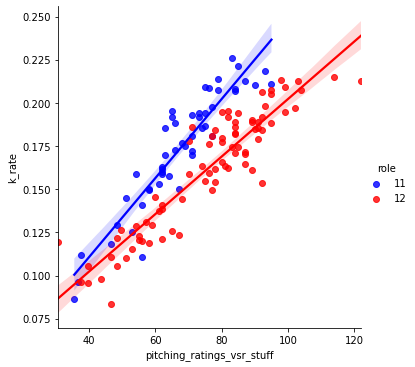

In [3]:
sns.lmplot(data=bz_relief.loc[bz_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsr_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

This divergence based on role is also present when looking at the pitcher's stuff rating versus LHB, so we can largely rule out any affects that the bronze meta has in terms of batter handedness playing a major impact, though how stuff plays up against RHB compared to LHB could still be different from each other.

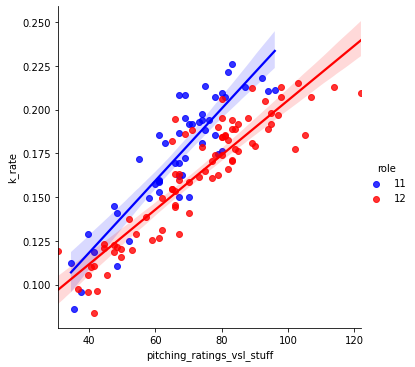

In [4]:
sns.lmplot(data=bz_relief.loc[bz_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsl_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

In general, pitchers that are listed as starters in the card database have higher strikeout percentages in relief than those pitchers who are listed as relievers or closers.

<AxesSubplot:xlabel='role_11', ylabel='k_rate'>

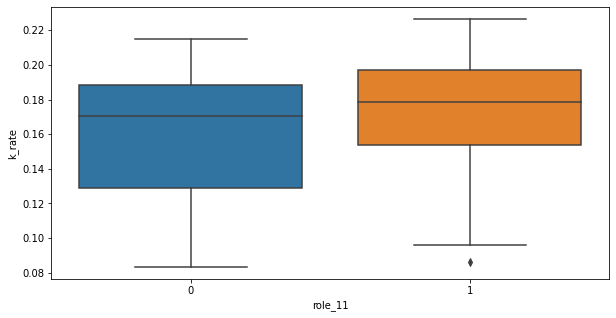

In [5]:
bz_relief['throws'] = bz_relief['throws'].astype('object')
bz_relief['role'] = bz_relief['role'].astype('object')

df = bz_relief[['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control','throws','role','k_rate']]

df = pd.get_dummies(df)

sns.boxplot(x="role_11", y="k_rate", data=df)

At this point we know that starting pitchers have higher strikeout rates than relievers while in the bullpen, while having lower stuff ratings than their relief counterparts.

We can get an approximate how much having an SP in the bullpen is worth in terms of stuff through linear regression. This section is not trying to find the best strikeout rate model possible, just an approximation. First I'll fit a model without a player's "role" being considered to see how it performs.

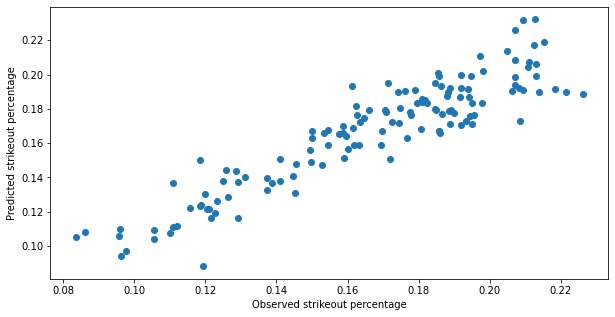

0.8476561002301687
0.0001789937950129868


In [6]:
x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control',
       'throws_1']

y = 'k_rate'

lr2 = linear_model.Ridge()

lr2.fit(df[x], df[y])

plt.scatter(df[y], lr2.predict(df[x]))
plt.xlabel('Observed strikeout percentage')
plt.ylabel('Predicted strikeout percentage')
plt.show()

print(metrics.r2_score(df[y], lr2.predict(df[x])))
print(metrics.mean_squared_error(df[y], lr2.predict(df[x])))

It's not the tightest fitting model I've ever produced in OOTP, but it's "generally" there. This has an r2 score of .848, and a mean squared error (MSE) of .00018.

How does a model with role added perform when predicting strikeout percentage?

{'pitching_ratings_vsr_stuff': 0.001141674651209968, 'pitching_ratings_vsr_movement': -0.00016648021199088263, 'pitching_ratings_vsr_control': 0.0004793014779399825, 'pitching_ratings_vsl_stuff': 0.0005541726493143536, 'pitching_ratings_vsl_movement': 1.480236645260123e-05, 'pitching_ratings_vsl_control': -0.0005126457747621978, 'throws_1': -0.006883347955730497, 'role_11': 0.019208899595065925}


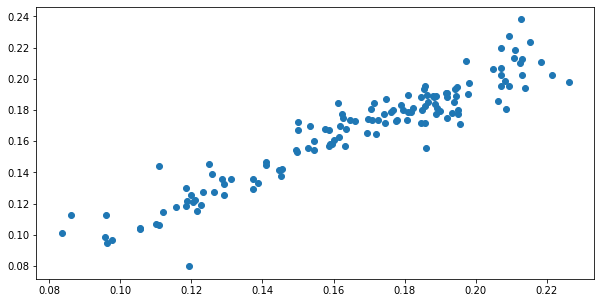

0.8936586061373003
0.00012494395695012098


In [7]:
x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'pitching_ratings_vsl_stuff',
       'pitching_ratings_vsl_movement', 'pitching_ratings_vsl_control', 'throws_1',
       'role_11']

lr = linear_model.Ridge()

lr.fit(df[x], df[y])

print(dict(zip(x, lr.coef_)))

plt.scatter(df[y], lr.predict(df[x]))
plt.show()

print(metrics.r2_score(df[y], lr.predict(df[x])))
print(metrics.mean_squared_error(df[y], lr.predict(df[x])))

It's a much tighter fit compared to the first model, has a higher r2 score, and a lower MSE, which supports the theory that stuff boost is still a game mechanic within OOTP Perfect Team.

How much of a boost do starters get to stuff in the second model?

In [8]:
print('Starters get a boost of about {:.2f} points to their stuff versus right-handed batters.'.format(lr.coef_[-1] / lr.coef_[0]))
print('Starters get a boost of about {:.2f} points to their stuff versus left-handed batters.'.format(lr.coef_[-1] / lr.coef_[3]))

Starters get a boost of about 16.83 points to their stuff versus right-handed batters.
Starters get a boost of about 34.66 points to their stuff versus left-handed batters.


Again, this is an approximation and has flaws since tournament data does not provide for splits. Just because cards listed as starters have approximately 17 points of stuff boost versus RHB doesn't mean ALL starters get an equal amount of boost. We know that starters that have two outstanding pitches, and middling supporting pitches get bigger boosts in the base game compared to starters with relatively equal pitches across the board.

To recap where things currently stand:
*  Pitchers who only appeared as relievers in Bronze Best-of-Seven Quick Tournmanets have differing strikeout rates when comparing their stuff.
*  This difference is best explained by the pitcher's role listed in the card database.
*  Pitchers who are listed as Starters in the card database have similar strikeout rates to Relievers despite having lower stuff than those Relievers.

**Relievers as Starters**

We've looked at starters in relief. What happens when a reliever is used as a starter? If a card listed as a reliever is used solely as a starter, we would expect something similar to happen, but in reverse: relievers would have lower strikeout rates than starters with similar sutff ratings.

The following section against uses data from the same Bronze Quick Best of Seven Tournmanets data from the first section. This time only pitchers who started the same number of games as they appeared in during the tournament are included. This s

The following data comes from Bronze Quick Best of Seven Tournmanets since the latest live card update that occured on June 28th, 2021. At the time I put this analysis together, I had pulled 270 tournaments worth of data, and approximately 3.7 million plate appearances. Since these pitchers never appeared in relief, it should control for the use of openers impacting the data and relative strikeout rates for pitchers.

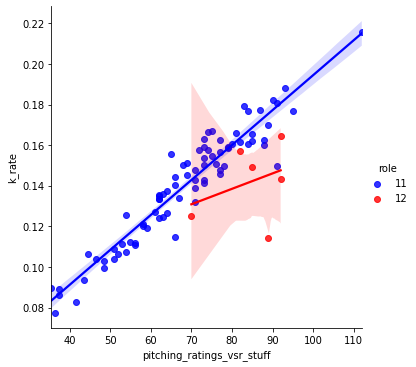

In [9]:
bz_start = pd.read_csv('bronze_starters.csv')
bz_start['pitching_ratings_vsr_stuff'] = bz_start['pitching_ratings_vsr_stuff'] / 2
bz_start['pitching_ratings_vsl_stuff'] = bz_start['pitching_ratings_vsl_stuff'] / 2
bz_start['k_rate'] = bz_start['k'] / bz_start['bf']

sns.lmplot(data=bz_start.loc[bz_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsr_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

There's only six pitchers that are listed as relievers in the card db that have appeared as only as a starter and faced more than 1,000 batters since the last live update, so there aren't a lot of observations to work with, however, it generally holds true that relievers have a strikeout rate lower than starters with the same stuff rating.

Who are these six relievers?

In [10]:
bz_start.loc[bz_start['role'] == 12, ['card_title', 'pitching_ratings_vsr_stuff', 'pitching_ratings_vsl_stuff', 'k_rate']]

,card_title,pitching_ratings_vsr_stuff,pitching_ratings_vsl_stuff,k_rate
0,Rookie Sensation RP Wayne Twitchell PHI 1972,89.0,84.0,0.114345
1,MLB 2021 Live RP Genesis Cabrera STL 2021,85.0,83.0,0.149031
2,MLB 2021 Live RP Tejay Antone CIN 2021,92.0,80.0,0.143533
3,MLB 2021 Live RP Tyler Chatwood TOR 2021,82.0,80.0,0.157363
4,MLB 2021 Live RP Clay Holmes PIT 2021,70.0,69.0,0.125098
5,MLB 2021 Live RP Michael Kopech CWS 2021,92.0,85.0,0.164396


The biggest outlier in the starters graph is Wayne Twitchell, a name synonmyous with bronze pitching. When looking at Twitchell's profile, his pitch ratings jump out as someone who would get a huge boost to stuff when shifted to the bullpen in the base game.

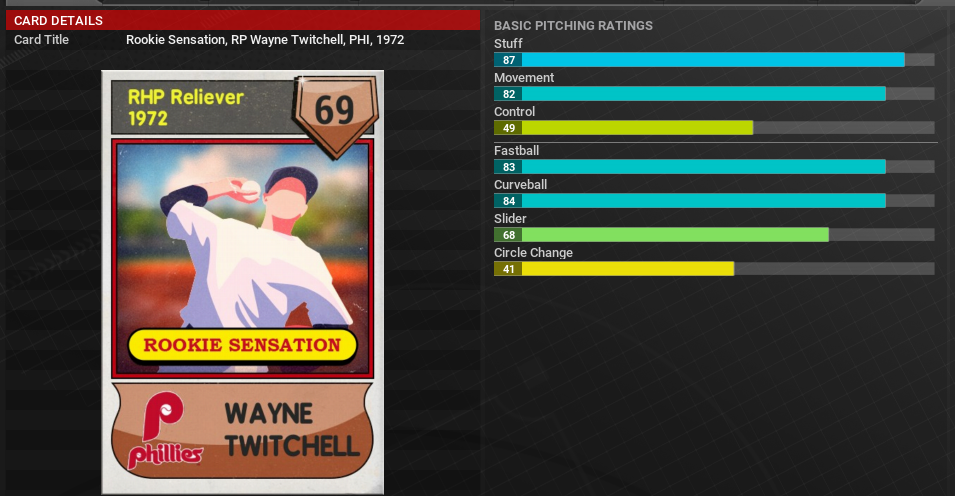

He's got two really great pitches, a middling third, and a horrible fourth (I say horrible because any pitch sub 50 in the base game is not good). Is he someone that would be expected to have a strikeout rate similar to Build-a-Legends Adam Wainwright, Charles Nagy and Tim Hudson in bronze with that profile though? I don't know, I wouldn't expect such a huge decline for someone like him in the base game, but the data isn't lying here.

Other pitchers in that list:
* Antone has two 70+ pitches, a 58 and 47. So his boost would be bigger than some of the others.
* Genesis Cabrera has an 84, and two mid-70s.
* Chatwood has three 70+ and two 60+. The more pitches a player has 50+ in the base game, the lower the stuff boost they generally get in the bullpen, and because of this his k-rate as a starter aligns mostly with other cards listed as starters with similar stuff.
* Clay Holmes has a 71, 67, 64 and 49. 
* Finally Michael Kopech, another one of the bigger outliers from the plot. He's got 82, 79, followed by 63 and 57. I believe this again is evidence that there's still stuff boost in the game.


This ends the look at bronze data from Perfect Team. There's clearly a boost for starters in the bullpen, and a "penalty" for relievers who start. Let's take a look at Silver.

**Silver Relievers**

The setup for this is the same as bronze data. Only pitchers who appeared as relievers for a team during the Silver Best of Seven Quick tournaments since the last live reset are included. There were no relievers that were used as starters in this time period.

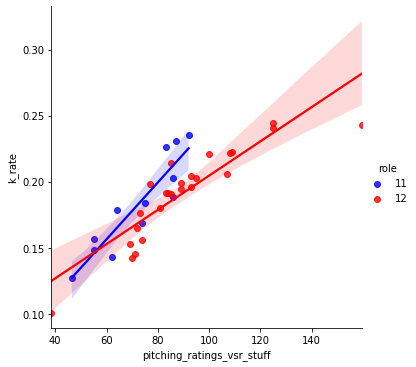

In [11]:
slv_relief = pd.read_csv('silver_relief.csv')
slv_relief['pitching_ratings_vsr_stuff'] = slv_relief['pitching_ratings_vsr_stuff'] / 2
slv_relief['pitching_ratings_vsl_stuff'] = slv_relief['pitching_ratings_vsl_stuff'] / 2
slv_relief['k_rate'] = slv_relief['k'] / slv_relief['bf']

sns.lmplot(data=slv_relief.loc[slv_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsr_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

There's not as many starters used as relievers in Silver tournaments during this time period, but the story seems to be the same to an extent. Starters in relief with higher strikeout rates have lower stuff ratings than relievers with similar strikeout rates.

Who are some of these starters?

In [12]:
slv_relief.loc[(slv_relief['role'] == 11) & (slv_relief['k_rate'] > .21),
               ['card_title', 'pitching_ratings_vsr_stuff', 'pitching_ratings_vsl_stuff', 'k_rate']
              ].sort_values(by='k_rate')

,card_title,pitching_ratings_vsr_stuff,pitching_ratings_vsl_stuff,k_rate
35,MLB 2021 Live SP Dustin May LAD 2021,83.0,82.0,0.226040
17,BUILD-A-LEGEND SP Ron Guidry New York Yankees ...,87.0,98.0,0.231158
13,BUILD-A-LEGEND SP Scott Kazmir Tampa Bay Devil...,92.0,99.0,0.235141


* Kazmir has a great changeup and two meh pitches. I could see a big boost here.
* Guidry has an 88 Slider, and two others at 79. Again, not someone you'd exect a huge boost to.
* Dustin May is two right around 70, another at 60 and a fourth at 51. The difference here is he throws 100mph, which is a contributor to larger stuff boosts, even if the underlying pitches aren't the best.


**League Data**

So Silver data appears to have the same affect. Let's turn to league data.

This comes from the prior two weeks (ending July 4th and July 11th) of Perfect League and Diamond League data provided by users to DRC's Discord channel, and publically available by anyone there to use and analyze.

I'll skip the look at relief pitchers as only starters since there's no relievers who only start in the league. However, there are plenty of starters who only ever appeared as relievers for their teams during the season. Given that splits are available for league data, it'll be a little easier to explore the impact of role on stuff boost.

First up, relievers who faced more than 1,000 right-handed batters during the last two weeks.

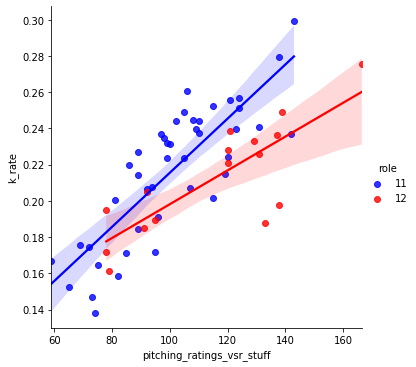

In [13]:
vsr_relief = pd.read_csv('vsr_league_relief.csv', index_col='card_id')
vsr_relief['pitching_ratings_vsr_stuff'] = vsr_relief['pitching_ratings_vsr_stuff'] / 2

vsr_relief['k_rate'] = vsr_relief['k'] / vsr_relief['bf']

sns.lmplot(data=vsr_relief.loc[vsr_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsr_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

It's a familiar looking sight at this point. Starters with lower stuff than relievers have similar, or higher, strikeout rates. In fact the two pitchers (Satchel Paige and FL Nate Pearson) with the highest strikeout rates are starters in the bullpen.

{'pitching_ratings_vsr_stuff': 0.0013411326908955138, 'pitching_ratings_vsr_movement': 8.878718877153037e-06, 'pitching_ratings_vsr_control': 0.0001249544348740332, 'throws_1': 0.034993348293366346, 'role_11': 0.02720401093136857}


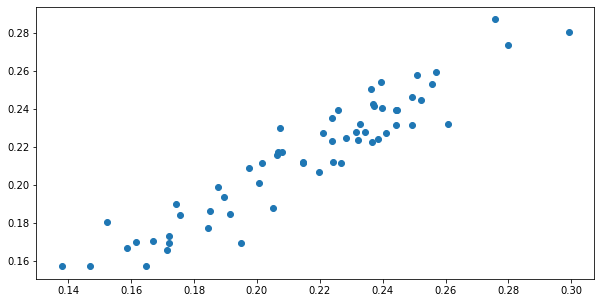

0.8892985435921895
0.00013419166158584126


In [14]:
vsr_relief['throws'] = vsr_relief['throws'].astype('object')
vsr_relief['role'] = vsr_relief['role'].astype('object')

df = vsr_relief[['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'throws','role','k_rate']]

df = pd.get_dummies(df)

y = 'k_rate'

x = ['pitching_ratings_vsr_stuff', 'pitching_ratings_vsr_movement',
       'pitching_ratings_vsr_control', 'throws_1', 'role_11']

lr = linear_model.Ridge()

lr.fit(df[x], df[y])

print(dict(zip(x, lr.coef_)))

plt.scatter(df[y], lr.predict(df[x]))
plt.show()

print(metrics.r2_score(df[y], lr.predict(df[x])))
print(metrics.mean_squared_error(df[y], lr.predict(df[x])))

Being listed as a SP in the card database is worth roughly 20 points worth of stuff when all things are kept equal for pitchers. Again, not every starter would receive the same boost to stuff when moved to the pen, it's very dependent on their individual pitches and velocity.

How about versus left-handed batters?

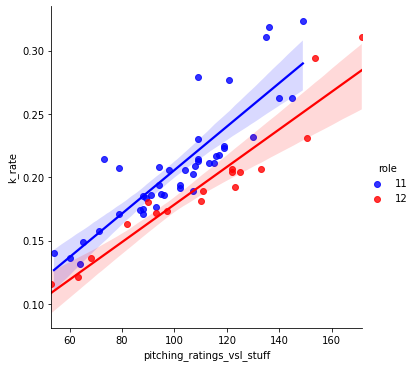

In [15]:
vsl_relief = pd.read_csv('vsl_league_relief.csv', index_col='card_id')
vsl_relief['pitching_ratings_vsl_stuff'] = vsl_relief['pitching_ratings_vsl_stuff'] / 2

vsl_relief['k_rate'] = vsl_relief['k'] / vsl_relief['bf']

sns.lmplot(data=vsl_relief.loc[vsl_relief['role'].isin([11,12]), :],
           x='pitching_ratings_vsl_stuff',
           y='k_rate', hue='role',
           palette=['blue','red'])

This plot looks a little different from the others in that there doesn't appear to be a "cross-over" at lower stuff ratings compred to bronze, silver, and league data versus RHB. Perhaps as stuff keeps decreaseing there would be a convergence. Despite this, there's still the difference in strikeout rates for starters and relievers.

{'pitching_ratings_vsl_stuff': 0.0013528167448847834, 'pitching_ratings_vsl_movement': 3.400060428277802e-06, 'pitching_ratings_vsl_control': -1.6757380182607996e-05, 'throws_1': -0.04915665271467753, 'role_11': 0.022563350225018756}


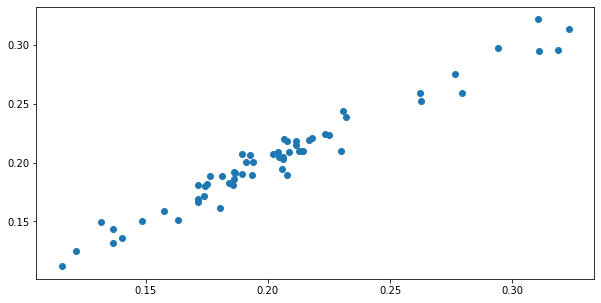

0.9603422800897966
8.589929615257805e-05


In [16]:
vsl_relief['throws'] = vsl_relief['throws'].astype('object')
vsl_relief['role'] = vsl_relief['role'].astype('object')

df = vsl_relief[['pitching_ratings_vsl_stuff', 'pitching_ratings_vsl_movement',
       'pitching_ratings_vsl_control', 'throws','role','k_rate']]

df = pd.get_dummies(df)

y = 'k_rate'

x = ['pitching_ratings_vsl_stuff', 'pitching_ratings_vsl_movement',
       'pitching_ratings_vsl_control', 'throws_1', 'role_11']

lr = linear_model.Ridge()

lr.fit(df[x], df[y])

print(dict(zip(x, lr.coef_)))

plt.scatter(df[y], lr.predict(df[x]))
plt.show()

print(metrics.r2_score(df[y], lr.predict(df[x])))
print(metrics.mean_squared_error(df[y], lr.predict(df[x])))

This model is the best fitting one of the bunch that has been produced so far, with an r2 score of .96 and and MSE of 0.000086. When all things are even, a SP in relief gets about a 17 point boost to their stuff.

**Conclusions**

Stuff boost is still modeled in the game engine within Perfect Team. It may not be displayed in the game when switching a pitchers role from SP to RP as it still happens within the base game, and previous versions of OOTP, but the engine is still applying the boost. After discussing this with some GMs who played previosu version of OOTP, they agree that it's still a game mechanic, albeit not at the level that was expereinced within PT 21.